# SUB REGION AND GRADCAM BOUNDING BOX

## Things to install and import

In [ ]:
# CLIP
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

# # REFCOCOG
!gdown 1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
!tar -xf /content/refcocog.tar.gz
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

#LAVIS
!pip install salesforce-lavis


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-y8fhtwj1
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-y8fhtwj1
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=c4c88e7f51b29b7d167ec51f320a13af4c0ab3100eabf2d69517fdd58ef47b2e
  Stored in directory: /tmp/pip-ephem-wheel-cache-hji8r2hk/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
Downloading...
From: https://drive.google.com/uc?id=1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
To: /con

In [ ]:
import clip
import json

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F

import numpy as np
import pandas
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import lavis
from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam
import locale
from typing import Sequence, Union
from scipy.ndimage import gaussian_filter


locale.getpreferredencoding = lambda: 'UTF-8'

blip_caption, image_preprocess_blip_cap, _ = lavis.models.load_model_and_preprocess(
    name='blip_caption', model_type='large_coco', is_eval=True, device='cuda'
    )

blip_im_text_match, image_preprocess_im_text_match, text_preprocess_im_text_match = lavis.models.load_model_and_preprocess(
    name="blip_image_text_matching", model_type="large", is_eval=True, device='cuda'
  )

modelCLIP, preprocessCLIP = clip.load("RN50", device='cuda')


100%|██████████| 1.66G/1.66G [01:15<00:00, 23.8MB/s]
100%|██████████| 3.43G/3.43G [03:06<00:00, 19.8MB/s]
100%|███████████████████████████████████████| 244M/244M [00:05<00:00, 50.8MiB/s]


## Functions to define

In [ ]:
def cosine_similarity(images_z: torch.Tensor, texts_z: torch.Tensor):
  # normalise the image and the text
  images_z /= images_z.norm(dim=-1, keepdim=True)
  texts_z /= texts_z.norm(dim=-1, keepdim=True)

  # evaluate the cosine similarity between the sets of features
  similarity = (texts_z @ images_z.T)

  return similarity.cpu()

In [ ]:
def rescale_image(image: Image, target_width: int = 720):
  w, h = image.size
  scale = target_width / w
  image = image.resize((int(w * scale), int(h * scale)))

  return image

def visualise_gradcam(
  gradcam, image: Image, text_tokens: torch.Tensor = None, average: bool = True, image_target_width: int = 720
):
  image = rescale_image(image, target_width=image_target_width)
  image_norm = np.float32(image) / 255

  if average:
    # get the average gradcap
    gradcam = getAttMap(image_norm, gradcam[0][1], blur=True)

    # plot gradcam
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    # ax.set_title(captions[common_idx[0]])
    ax.imshow(gradcam)
    ax.axis('off')
    fig.tight_layout()
  else:
    # get the number of images from the number of tokens
    num_image = len(text_tokens.input_ids[0]) - 2

    # create the image
    fig, ax = plt.subplots(num_image, 1, figsize=(15, 5 * num_image))

    # create the iterators  
    gradcam_iter = iter(gradcam[0][2:-1])
    token_id_iter = iter(text_tokens.input_ids[0][1:-1])

    # plot an ax for each token
    for i, (gradcam, token_id) in enumerate(zip(gradcam_iter, token_id_iter)):
      word = modelCLIP.tokenizer.decode([token_id])
      gradcam_image = getAttMap(image_norm, gradcam, blur=True)
      ax[i].imshow(gradcam_image)
      ax[i].set_yticks([])
      ax[i].set_xticks([])
      ax[i].set_xlabel(word)


In [ ]:
def sub_region(image, target, modelCLIP, preprocessCLIP):
  '''
  Args:
  ..............................
  Return:
  ..............................
  '''

  # CANDIDATE SUB-REGIONS
  image_pecies_final = [image]
  A, B = image.size
  for i in range(3):
    im = image.crop((A/4*i,0,A/4*i+A/2,B))
    image_pecies_final.append(im)

  for j in range(3):
    im = image.crop((0,B/4*j,A,B/4*j+B/2))
    image_pecies_final.append(im)

  # IMAGE FRAGMENTS
  image_pecies = []
  A, B = image.size
  for j in range(3):
    for i in range(3):
      im = image.crop((A/4*i,B/4*j,A/4*i+A/2,B/4*j+B/2))
      image_pecies.append(im)

  # ENCODING
  images = [preprocessCLIP(im) for im in image_pecies]
  images = torch.tensor(np.stack(images)).cuda()

  with torch.no_grad():
    images_z = modelCLIP.encode_image(images).float()

  #TARGET
  target_caption = clip.tokenize(target).cuda()

  with torch.no_grad():
      target_caption_z = modelCLIP.encode_text(target_caption).float()
  
  # IMAGE SIMILARITIES
  im_sim = torch.Tensor(0)

  for im in images_z:
    similarity = cosine_similarity(im, target_caption_z)
    im_sim = torch.cat((im_sim, similarity),0)

  a, b = torch.topk(im_sim, 5, sorted=True)
  for i in range(5):
    if a[i]<0.15 :
      b = b[0:i]
      break

  if a[0]>0.20:
    # plt.figure(figsize=(5,5))
    # plt.imshow(image_pecies[b[0]])
    return image_pecies[b[0]], 10
  print('Valid Indexes:', b, '\tSimilarities:', a)

  common_idx=b.tolist()
  a = 0
  if all(x in common_idx for x in [0, 1, 2]):
    a = 1
  elif all(x in common_idx for x in [3, 4, 5]):
    a = 2
  elif all(x in common_idx for x in [6, 7, 8]):
    a = 3
  elif all(x in common_idx for x in [0, 3, 6]):
    a = 4
  elif all(x in common_idx for x in [1, 4, 7]):
    a = 5
  elif all(x in common_idx for x in [2, 5, 8]):
    a = 6
  
  print('Selected sub-region:', a)

  return image_pecies_final[a], a


## Work with the RefCocog dataset

# INTEGRAZIONE A CODICE FRANCESCO

### Dataset

In [ ]:
class RefcocogDataset(Dataset):
    def __init__(self, base_path, split=None, transform=None, tokenization=None):
        annotation_path = base_path + "/annotations/"

        self.IMAGES_PATH = base_path + "/images/"
        self.transform = transform
        self.tokenization = tokenization

        tmp_annotations = pandas.read_pickle(annotation_path + "refs(umd).p")
        tmp_instances = json.load(open(annotation_path + "instances.json", "r"))

        annotations_dt = pandas.DataFrame.from_records(tmp_annotations) \
            .filter(items=["image_id", "split", "sentences", "ann_id"])

        instances_dt = pandas.DataFrame.from_records(tmp_instances['annotations'])

        self.annotations = annotations_dt \
            .merge(instances_dt[["id", "bbox", "area"]], left_on="ann_id", right_on="id") \
            .drop(columns="id")

        if split is not None:
            self.annotations = self.__get_annotations_by_split(split.lower())

    def getImage(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]
        image = self.__getimage(item.image_id)

        return image

    def getSentences(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]

        return self.__extract_sentences(item.sentences)
    
    def showImage(self, train_features, train_bbox):
        img = self.getImage(train_features)
        img1 = ImageDraw.Draw(img)
        img1.rectangle([(train_bbox[0].item(), train_bbox[1].item()), (train_bbox[2].item(), train_bbox[3].item())], outline ="red")
        img.show()

    def __get_annotations_by_split(self, split):
        return self.annotations[self.annotations.split == split].reset_index()

    def __getimage(self, id):
        return Image.open(self.IMAGES_PATH + "COCO_train2014_" + str(id).zfill(12) + ".jpg")

    def __extract_sentences(self, sentences):
        return [f"a photo of {s['sent']}" for s in sentences]

    def __tokenize_sents(self, sentences):
        return [self.tokenization(s) for s in sentences]

    def __len__(self):
        return self.annotations.shape[0]

    def __getitem__(self, idx):
        item = self.annotations.iloc[idx]
        image = self.__getimage(item.image_id)
        sentences = self.__extract_sentences(item.sentences)

        if self.transform:
            image = self.transform(image)

        if self.tokenization:
            sentences = self.__tokenize_sents(sentences)

        sample = {'idx': idx, 'image': image, 'sentences': sentences}

        return sample, item.bbox

In [ ]:
REFCOCOG_PATH = "refcocog"

train_dataset = RefcocogDataset(REFCOCOG_PATH, split="train", transform=preprocessCLIP, tokenization=clip.tokenize)
val_dataset = RefcocogDataset(REFCOCOG_PATH, split="val", transform=preprocessCLIP, tokenization=clip.tokenize)
test_dataset = RefcocogDataset(REFCOCOG_PATH, split="test", transform=preprocessCLIP, tokenization=clip.tokenize)

train_dataloader = DataLoader(train_dataset, shuffle=False)
val_dataloader = DataLoader(val_dataset, shuffle=False)
test_dataloader = DataLoader(test_dataset, shuffle=False)

### Gradcam e altre funzioni

In [ ]:
# def normalize(x: np.ndarray) -> np.ndarray:
#     x = x - x.min()
#     if x.max() > 0:
#         x = x / x.max()
#     return x

# def getAttMap(img, attn_map, blur=True):
#     if blur:
#         attn_map = gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
#     attn_map = normalize(attn_map)
#     cmap = plt.get_cmap('jet')
#     attn_map_c = np.delete(cmap(attn_map), 3, 2)
#     attn_map = 1*(1-attn_map**0.7).reshape(attn_map.shape + (1,))*img + \
#             (attn_map**0.7).reshape(attn_map.shape+(1,)) * attn_map_c
#     return attn_map

# def getCmap(img, attn_map, blur=True):
#     if blur:
#         attn_map = gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
#     attn_map = normalize(attn_map)
#     cmap = plt.get_cmap('jet')
#     attn_map_c = np.delete(cmap(attn_map), 3, 2)
#     return attn_map_c

# def viz_attn(img, attn_map, blur=True):
#     _, axes = plt.subplots(1, 2, figsize=(10, 5))
#     axes[0].imshow(img)
#     axes[1].imshow(getAttMap(img, attn_map, blur))
#     for ax in axes:
#         ax.axis("off")
#     plt.show()
    
# def load_image(image, resize=None):
#     image = image.convert("RGB")
#     if resize is not None:
#         image = image.resize((resize, resize))
#     return np.asarray(image).astype(np.float32) / 255.


# class Hook:
#     def __init__(self, module: nn.Module):
#         self.data = None
#         self.hook = module.register_forward_hook(self.save_grad)
        
#     def save_grad(self, module, input, output):
#         self.data = output
#         output.requires_grad_(True)
#         output.retain_grad()
        
#     def __enter__(self):
#         return self
    
#     def __exit__(self, exc_type, exc_value, exc_traceback):
#         self.hook.remove()

#     def activation(self) -> torch.Tensor:
#         return self.data
    

#     def gradient(self) -> torch.Tensor:
#         return self.data.grad


# def gradCAM(model: nn.Module, input: torch.Tensor, target: torch.Tensor, layer: nn.Module) -> torch.Tensor:
#     if input.grad is not None:
#         input.grad.data.zero_()
    
#     requires_grad = {}
#     for name, param in model.named_parameters():
#         requires_grad[name] = param.requires_grad
#         param.requires_grad_(False)
        
#     assert isinstance(layer, nn.Module)
#     with Hook(layer) as hook:        
#         output = model(input)
#         output.backward(target)

#         grad = hook.gradient.float()
#         act = hook.activation.float()
    
#         alpha = grad.mean(dim=(2, 3), keepdim=True)
#         gradcam = torch.sum(act * alpha, dim=1, keepdim=True)
#         gradcam = torch.clamp(gradcam, min=0)

#     gradcam = F.interpolate(gradcam, input.shape[2:], mode='bicubic', align_corners=False)
    
#     for name, param in model.named_parameters():
#         param.requires_grad_(requires_grad[name])
        
#     return gradcam


# class FeatureCouple:
#     def __init__(self, index, image_feature, sentence_feature, norm_image_feature, norm_sentence_feature):
#         self.index = index
#         self.image_feature = image_feature
#         self.sentence_feature = sentence_feature
#         self.similarity = norm_image_feature * norm_sentence_feature


# def getSalientEncodedFeatures(preprocessed_image, encoded_text, model):
#     with torch.no_grad():
#         encoded_image = model.encode_image(preprocessed_image).float()
#         norm_encoded_image = encoded_image / encoded_image.norm(dim=-1, keepdim=True)
#         norm_encoded_text = encoded_text / encoded_text.norm(dim=-1, keepdim=True)
#         original_sim = norm_encoded_text.cpu().numpy() @ norm_encoded_image.cpu().numpy().T
    

#         features = []
#         for i in range(1024):
#             features.append(FeatureCouple(i, encoded_image[0][i].item(), encoded_text[0][i].item(), norm_encoded_image[0][i].item(), norm_encoded_text[0][i].item()))
#         features.sort(key=lambda x: x.similarity, reverse=True)

#         reconstruct_indexes = set()
#         reconstruct_sim = 0
#         for elem in features:
#             if reconstruct_sim / original_sim < 0.95:
#                 reconstruct_sim += elem.similarity
#                 reconstruct_indexes.add(elem.index)

#         for index in range(1024):
#             if index not in reconstruct_indexes:
#                 encoded_text[0][index] = 0
#                 encoded_image[0][index] = 0
#                 norm_encoded_image[0][index] = 0
#                 norm_encoded_text[0][index] = 0
    
#     return encoded_image, encoded_text
#     return norm_encoded_image, norm_encoded_text

In [ ]:
# def computeIntersection(fx1, fy1, fx2, fy2, sx1, sy1, sx2, sy2):
#     dx = min(fx2, sx2) - max(fx1, sx1)
#     dy = min(fy2, sy2) - max(fy1, sy1)
#     if (dx>=0) and (dy>=0):
#         area = dx*dy
#     else:
#         area = 0
#     return area

# def computeAccuracy(bbox, label):
#     intersection = computeIntersection(bbox[0], bbox[1], bbox[2], bbox[3],
#                                        label[0].item(), label[1].item(), label[0].item()+label[2].item(), label[1].item()+label[3].item())
#     area1 = (bbox[2]-bbox[0])*(bbox[3]-bbox[1])
#     area2 = label[2].item()*label[3].item()
#     union = area1 + area2 - intersection
#     return intersection / union

# def computePrecision(bbox, label):
#     intersection = computeIntersection(bbox[0], bbox[1], bbox[2], bbox[3],
#                                        label[0].item(), label[1].item(), label[0].item()+label[2].item(), label[1].item()+label[3].item())
#     area1 = (bbox[2]-bbox[0])*(bbox[3]-bbox[1])
#     area2 = label[2].item()*label[3].item()
#     union = area1 + area2 - intersection
#     return intersection / area2


### BASELINE

In [ ]:
modelCLIP.cuda().eval()
device = 'cuda'

def baseline(loader, dataset, modelCLIP, preprocessCLIP, num_samples):

  stop = 1
  delay = 0

  n_samples = 0
  tot_accuracy = 0
  tot_precision = 0
  blur = False

  for data_features, data_bbox in loader:
    sentences = dataset.getSentences(data_features)
    minxs = []
    minys = []
    maxxs = []
    maxys = []

    delay += 1
    #------------------------
    if delay<num_samples: continue
    #------------------------
    
    for sent in sentences:
        
        print('TARGET:',sent)
        image = dataset.getImage(data_features)        

        # GRADCAM VISUALIZATION OF THE WHOLE IMAGE
        target = sent
        input_text = text_preprocess_im_text_match["eval"](target)
        input_image = image_preprocess_im_text_match["eval"](image).unsqueeze(0).cuda()
        text_tokens = blip_im_text_match.tokenizer(input_text, return_tensors="pt").to('cuda')
        gradcam, _ = compute_gradcam(
            blip_im_text_match, input_image, input_text, text_tokens, block_num=7
          )
        visualise_gradcam(gradcam, image, text_tokens=text_tokens, average=True)

        # FIND THE RIGHT SUBREGION
        Sub_Region, a = sub_region(image, target, modelCLIP, preprocessCLIP)

        # GRADCAM VISUALIZATION OF THE SUB-REGION
        input_image = image_preprocess_im_text_match["eval"](Sub_Region).unsqueeze(0).cuda()
        text_tokens = blip_im_text_match.tokenizer(input_text, return_tensors="pt").to('cuda')
        gradcam, _ = compute_gradcam(
            blip_im_text_match, input_image, input_text, text_tokens, block_num=7
          )
        visualise_gradcam(gradcam, Sub_Region, text_tokens=text_tokens, average=True)


        #      maxys.append(max(ys)*scaling_factor_y + original_size[1]/2)  
        break


        #-------------------------------------------------------------------------------------------------------------

    #     preprocessed_image = preprocessCLIP(image).unsqueeze(0).to(device)
    #     encoded_text = modelCLIP.encode_text(clip.tokenize([sent]).to(device)).float()
    #     # encoded_image, encoded_text = getSalientEncodedFeatures(preprocessed_image, encoded_text, modelCLIP)
    #     attn_map = gradCAM(modelCLIP.visual, preprocessed_image, encoded_text, getattr(modelCLIP.visual, "layer4"))
    #     attn_map = attn_map.squeeze().detach().cpu().numpy()
    #     #viz_attn(load_image(image, modelCLIP.visual.input_resolution), attn_map, blur)
    #     cmap = getCmap(load_image(image, modelCLIP.visual.input_resolution), attn_map, blur)
    #     red = torch.zeros((224, 224))
    #     for i in range(cmap.shape[0]):
    #         for j in range(cmap.shape[1]):
    #             for k in range(cmap.shape[2]):
    #                 red[i][j] = cmap[i][j][0]
    #     xs = []
    #     ys = []
    #     for i in range(224):
    #         for j in range(224):
    #             if red[i][j] > 0.5:
    #                 xs.append(j)
    #                 ys.append(i)
        
    #     #----------------------
    #     # if a==0:
    #     #   original_size = dataset.getImage(data_features).size
    #     #   scaling_factor_x = original_size[0]/224
    #     #   scaling_factor_y = original_size[1]/224
    #     # elif a == 1 :
    #     #   original_size = dataset.getImage(data_features).size
    #     #   scaling_factor_x = original_size[0]/224
    #     #   scaling_factor_y = original_size[1]/224
    #     # elif a == 2 :
    #     #   original_size = dataset.getImage(data_features).size
    #     #   scaling_factor_x = original_size[0]/224
    #     #   scaling_factor_y = original_size[1]/224
    #     # elif a == 3 :
    #     #   original_size = dataset.getImage(data_features).size
    #     #   scaling_factor_x = original_size[0]/224
    #     #   scaling_factor_y = original_size[1]/224
    #     # elif a == 4 :
    #     #   original_size = dataset.getImage(data_features).size
    #     #   scaling_factor_x = original_size[0]/224
    #     #   scaling_factor_y = original_size[1]/224
    #     # elif a == 5 :
    #     #   original_size = dataset.getImage(data_features).size
    #     #   scaling_factor_x = original_size[0]/224
    #     #   scaling_factor_y = original_size[1]/224
    #     # elif a == 6 :
    #     #   original_size = dataset.getImage(data_features).size
    #     #   scaling_factor_x = original_size[0]/224
    #     #   scaling_factor_y = original_size[1]/224
    #     #----------------------
    #     original_size = dataset.getImage(data_features).size
    #     scaling_factor_x = original_size[0]/224
    #     scaling_factor_y = original_size[1]/224
    #     if(len(xs) > 0 and len(ys) > 0):
    #         # minxs.append(min(xs)*scaling_factor_x)
    #         # minys.append(min(ys)*scaling_factor_y)
    #         # maxxs.append(max(xs)*scaling_factor_x)
    #         # maxys.append(max(ys)*scaling_factor_y)
    #         # print(a)
    #         if a == 0:
    #           minxs.append(min(xs)*scaling_factor_x)
    #           minys.append(min(ys)*scaling_factor_y)
    #           maxxs.append(max(xs)*scaling_factor_x)
    #           maxys.append(max(ys)*scaling_factor_y)
    #         elif a == 1:
    #           minxs.append(min(xs)*scaling_factor_x)
    #           minys.append(min(ys)*scaling_factor_y)
    #           maxxs.append(max(xs)*scaling_factor_x)
    #           maxys.append(max(ys)*scaling_factor_y) 
    #         elif a == 2:
    #           minxs.append(min(xs)*scaling_factor_x + original_size[0]/4)
    #           minys.append(min(ys)*scaling_factor_y)
    #           maxxs.append(max(xs)*scaling_factor_x + original_size[0]/4)
    #           maxys.append(max(ys)*scaling_factor_y)
    #         elif a == 3:
    #           minxs.append(min(xs)*scaling_factor_x + original_size[0]/2)
    #           minys.append(min(ys)*scaling_factor_y)
    #           maxxs.append(max(xs)*scaling_factor_x + original_size[0]/2)
    #           maxys.append(max(ys)*scaling_factor_y)
    #         elif a == 4:
    #           minxs.append(min(xs)*scaling_factor_x)
    #           minys.append(min(ys)*scaling_factor_y)
    #           maxxs.append(max(xs)*scaling_factor_x)
    #           maxys.append(max(ys)*scaling_factor_y)
    #         elif a == 5:
    #           minxs.append(min(xs)*scaling_factor_x)
    #           minys.append(min(ys)*scaling_factor_y + original_size[1]/4)
    #           maxxs.append(max(xs)*scaling_factor_x)
    #           maxys.append(max(ys)*scaling_factor_y + original_size[1]/4)             
    #         elif a == 6:
    #           minxs.append(min(xs)*scaling_factor_x)
    #           minys.append(min(ys)*scaling_factor_y + original_size[1]/2)
    #           maxxs.append(max(xs)*scaling_factor_x)
    #           maxys.append(max(ys)*scaling_factor_y + original_size[1]/2)  
    #     break
    
    # if(len(minxs) > 0 and len(minys) > 0 and len(maxxs) > 0 and len(maxys) > 0):
    #     bbox = [sum(minxs)/len(minxs), sum(minys)/len(minys), sum(maxxs)/len(maxxs), sum(maxys)/len(maxys)]
    #     accuracy = computeAccuracy(bbox, data_bbox)
    #     precision = computePrecision(bbox, data_bbox)
    #     tot_accuracy += accuracy
    #     tot_precision += precision
    #     n_samples += 1
    #     f.write(f'Image {n_samples:^8}/{len(dataset):^8}\t{accuracy}\t{precision}\n')
    #     if(a==0):
    #       print(f'Image {n_samples:^8}/{len(dataset):^8}\t{accuracy}\t{precision}\ttotal image')
    #     elif(a==1 | a==4):
    #       print(f'Image {n_samples:^8}/{len(dataset):^8}\t{accuracy}\t{precision}\tnot traslated')
    #     else:
    #       print(f'Image {n_samples:^8}/{len(dataset):^8}\t{accuracy}\t{precision}\ttraslated')
    # else:
    #     n_samples += 1
    #     f.write(f'Image {n_samples:^8}/{len(dataset):^8}\terror\n')
    #     print(f'Image {n_samples:^8}/{len(dataset):^8}\terror')
    
    
    # break
    # if stop%100==0:
    #   print('Partial accuracy:',tot_accuracy/n_samples)
    #   print('Partial precision:',tot_precision/n_samples)
    # stop+=1
    #------------------------------------------------------------------------------------------------------
    
    # if(len(minxs) > 0 and len(minys) > 0 and len(maxxs) > 0 and len(maxys) > 0):
    #     bbox = [sum(minxs)/len(minxs), sum(minys)/len(minys), sum(maxxs)/len(maxxs), sum(maxys)/len(maxys)]
    #     accuracy = computeAccuracy(bbox, data_bbox)
    #     precision = computePrecision(bbox, data_bbox)
    #     tot_accuracy += accuracy
    #     tot_precision += precision
    #     n_samples += 1
    #     if(a==0):
    #       print(f'Image {n_samples:^8}/{len(dataset):^8}\t{accuracy}\t{precision}\ttotal image')
    #     elif(a==1 | a==4):
    #       print(f'Image {n_samples:^8}/{len(dataset):^8}\t{accuracy}\t{precision}\tnot traslated')
    #     else:
    #       print(f'Image {n_samples:^8}/{len(dataset):^8}\t{accuracy}\t{precision}\ttraslated')
    # else:
    #     n_samples += 1
    #     print(f'Image {n_samples:^8}/{len(dataset):^8}\terror')
    
    
    #---------------------------------------------------------------
    break
    if stop%100==0:
      print('Partial accuracy:',tot_accuracy/n_samples)
      print('Partial precision:',tot_precision/n_samples)
    stop+=1
    #---------------------------------------------------------------

  return #tot_accuracy/n_samples
  

# Run the baseline

TARGET: a photo of the black dog with the blue collar . on the left


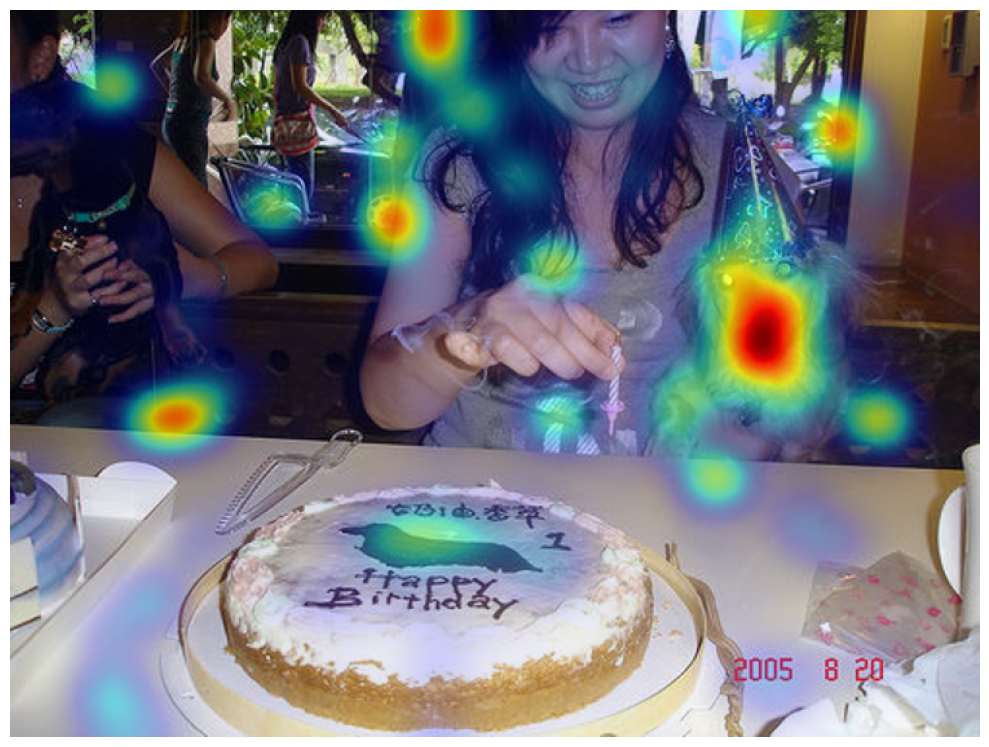

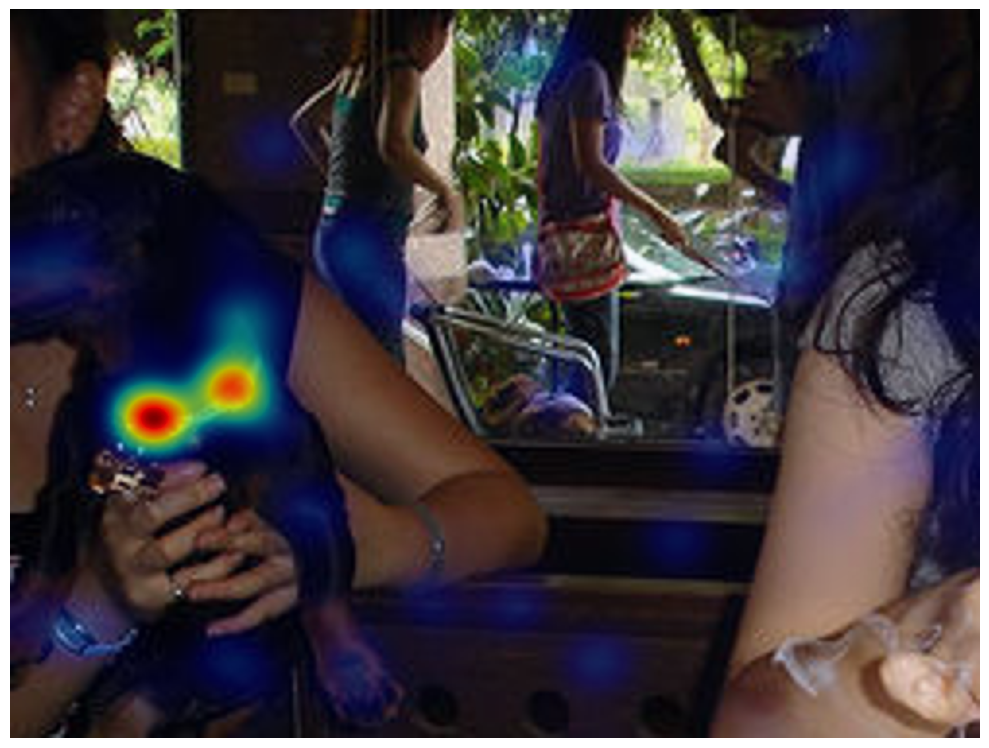

In [ ]:
baseline(val_dataloader, val_dataset, modelCLIP, preprocessCLIP, num_samples=10)